In [1]:
!pip install tfa-nightly
!pip install pygame

     |████████████████████████████████| 1.1 MB 14.8 MB/s 
     |████████████████████████████████| 13.8 MB 15.1 MB/s 


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from difflib import SequenceMatcher

import random
import json
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from keras.regularizers import l2, L1
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from sklearn.model_selection import train_test_split

import pygame
from IPython.display import Image, display

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
  tf.config.experimental.set_memory_growth(gpu, True)

print("Tensorflow version is: ", tf.__version__)
assert tf.__version__[0] == '2'

%load_ext tensorboard

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Tensorflow version is:  2.6.0
Tue Oct 19 21:43:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   25C    P8     3W /  N/A |    499MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------

# Data Processing Functions

In [4]:
def convert_to_df(lines):
    all_rows = []
    index = 0
    num_tunes = 0

    # For each line in the file, 
    for line in lines:

        # To ensure we skip the newlines 
        if len(line) > 1:

            print(line)

            # If the line has an X (index value)
            if line[0] == 'X':

                # If this not the first line 
                if index != 0: 

                    # Add everything in dict_line to the all_rows list
                    all_rows.append(dict_line)
                    print("**** Added info: Added dict_line to all rows ****")
                    print()

                # Create an empty dict 
                dict_line = {}
                dict_line['transcription'] = ''

                index += 1
                num_tunes += 1

                print("**** Added info: Dictionary reinitialized ****")
                print()

                continue

            # else if the line has an M, 
            elif line[0] == 'M':

                # Save everything after the colon to dict_line with key 'M'
                dict_line['M'] = line[2:].strip()
                print("**** Added info: Dictionary added M = " + dict_line['M'] + " ****")
                print()
                continue

            # else if the line has a K, 
            elif line[0] == 'K':

                # Save everything after the colon to dict_line with key 'K'
                dict_line['K'] = line[2:].strip()
                print("**** Added info: Dictionary added K = " + dict_line['K'] + " ****")
                print()

            # else if the conditions for it being the transcription are true, 
            elif (line[0] == "|" or line[1] != ":") and (line[0] != "%") and (line != ''):

                # Add that to the dict_line with key 'transcription'
                dict_line['transcription'] += line.strip()
                print("**** Added info : Dictionary added transcription ****")
                print()        


    df = pd.DataFrame(all_rows)
    return df


# Version of previous function that takes in just one generated sample and returns a dictionaty in the 
# dict_line format from the previous function
def convert_sample_to_dict(generated_sample):
    
    dict_line = {}
    dict_line['transcription'] = ''
    
    # For each line in the generated sample, 
    for line in generated_sample.splitlines():
        
        # To ensure we skip the newlines 
        if len(line) > 1:
            
            # if the line has an M,
            if line[0] == "M":    
                
                # Save everything after the colon to dict_line with key 'M'
                dict_line['M'] = line[2:].strip()
                continue
            
            # else if the line has a K,
            elif line[0] == 'K':
                
                # Save everything after the colon to dict_line with key 'K'
                dict_line['K'] = line[2:].strip()
                continue
            
            # else if the conditions for it being the transcription are true, 
            elif (line[0] == "|" or line[1] != ":") and (line[0] != "%") and (line != ''):
                
                # Add that to the dict_line with key 'transcription'
                dict_line['transcription'] += line.strip()
                
    
    return dict_line


# Function that gives each character an index number and returns a dictionary (as well as a reversed dictionary)
def give_characters_indexes(data):

    char_index_dict = {}
    index_char_dict = {}
    for (i, char) in enumerate(sorted(list(set(data)))):
        char_index_dict[char] = i
        index_char_dict[i] = char

    with open(data_directory + char_index_json, mode = "w") as f:
        json.dump(char_index_dict, f)

    return char_index_dict, index_char_dict


# Sequence Generator Functions

In [5]:
# Function taken and modified from here - https://medium.datadriveninvestor.com/music-generation-using-deep-learning-85010fb982e2 
def generate_sequence(epoch_num, initial_index, seq_length):
    
    char_index_dict, index_char_dict = give_characters_indexes(data)
    num_unique_chars = len(index_char_dict)
    
    #print(char_index_dict)
    #print(index_char_dict)
    #print(num_unique_chars)

    #with open(os.path.join(data_directory, charIndex_json)) as f:
    #    char_to_index = json.load(f)
    #index_to_char = {i:ch for ch, i in char_to_index.items()}
    #num_unique_chars = len(index_to_char)
    

    generator_model = make_model(num_unique_chars)
    weights_dir = model_weights_directory + "Weights_{}.h5".format(num_epochs)
    generator_model.load_weights(weights_dir)
    #print(f"Loaded {weights_dir}")

    sequence_index = [initial_index]
    
    for _ in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = generator_model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(num_unique_chars), size = 1, p = predicted_probs)
        sequence_index.append(sample[0])
    
    seq = ''.join(index_char_dict[c] for c in sequence_index)
    
    #print(f"SEQ: {seq}"
    
    if seq == '':
        return ''

    cnt = 0
    if len(seq) > 1:
        
        for j in seq:
            cnt += 1
            if j == "\n":
                break
        seq1 = seq[cnt:]
    else:
        return ''
    #print(f"SEQ1: {seq1}")
    #above code is for ignoring the starting string of a generated sequence. This is because we are passing any arbitrary 
    #character to the model for generating music. Now, the model start generating sequence from that character itself which we 
    #have passed, so first few characters before "\n" contains meaningless word. Model start generating the music rhythm from
    #next line onwards. The correct sequence it start generating from next line onwards which we are considering.
    
    if seq1 == '':
        return ''

    cnt = 0

    if len(seq1) > 1:
        for j in seq1:
            cnt += 1
            if j == "\n":
                if len(seq1) > cnt:
                    if seq1[cnt] == "\n":
                        break
        seq2 = seq1[:cnt]
    else:
        return ''
    #print(f"SEQ2: {seq2}")
    #Now our data contains three newline characters after every tune. So, the model has leart that too. So, above code is used for
    #ignoring all the characters that model has generated after three new line characters. So, here we are considering only one
    #tune of music at a time and finally we are returning it..
    
    return seq2


# Evaluation Functions


In [6]:
# Function that takes care of the 'Distribution Similarity' pillar
def compare_distributions(music_df, generated_df, metric):
    
    # Get the value counts of both the datasets
    generated_df_val_counts = dict(generated_df[metric].value_counts(normalize=True, ascending=False))
    music_df_val_counts = dict(music_df[metric].value_counts(normalize=True, ascending=False))
    
    print()
    print("Original Dataset Distribution")
    print(music_df_val_counts)
    print("Generated Dataset Distribution")
    print(generated_df_val_counts)
    
    # Add the missing keys from each dataset to the otehr
    for key in music_df_val_counts.keys():
        if key not in generated_df_val_counts.keys():
            generated_df_val_counts[key] = 0

    unique_keys = []
    for key in generated_df_val_counts.keys():
        if key not in music_df_val_counts.keys():
            unique_keys.append(key)
            music_df_val_counts[key] = 0

    print()
    print(f"Unique '{metric}' values to generated dataset: {unique_keys}")
    print()

    # Plot the figure for both distributions
    plt.figure(figsize=(15,7))
    plt.grid(True)
    
    # Number of bars we want for the figure
    num_bars = np.arange(len(music_df_val_counts))           
    width = 0.3
    
    plt.bar(num_bars, music_df_val_counts.values() , width, label='Original Dataset')
    plt.bar(num_bars + width, generated_df_val_counts.values(), width, label='Generated Dataset')
    plt.xticks(num_bars + width / 2, music_df_val_counts.keys())
    plt.legend(loc='best')
    plt.show()

    
    
# Function that takes care of the 'Error Rate' pillar
def determine_error_rate(generated_df):

    num_errors = 0
    for i in range(len(generated_df)):
        
        # If the transcription is empty
        if (generated_df.iloc[i]['transcription'] == ''):
            num_errors += 1
        
        # Else if the transcription is null
        elif (pd.isnull(generated_df.iloc[i]['transcription'])):
            num_errors += 1
        
        # Else if the 'K' value is null
        elif pd.isnull(generated_df.iloc[i]['K']):
            num_errors += 1
        
        # Else if the 'K' value has any characters other than letters
        elif not (all(i.isalpha() for i in generated_df.iloc[i]['K'])):
            num_errors += 1
        
        # Else if the 'M' valye is null
        elif pd.isnull(generated_df.iloc[i]['M']):
            num_errors += 1
        
        # Else if the 'M' value has any letters
        elif (any(i.isalpha() for i in generated_df.iloc[i]['M'])):
            num_errors += 1
        
    error_rate = (num_errors / len(generated_df)) * 100
        
    return error_rate

# Function that takes care of the "Average Maximum Similarity Score" pillar
def get_average_similarity_score(music_df, generated_df):
    
    total_similarity_score = 0
    
    # For each generated sample
    for i in range(len(generated_df)):
        
        # Get the transcription value from the dataframe
        generated_sample = generated_df.iloc[i]["transcription"]
        max_similarity_score = 0
        
        # For each training sample
        for j in range(len(music_df)):
            
            # Get the transcription value from the dataframe
            original_sample = music_df.iloc[j]["transcription"]
            
            # Calculate the similarity score
            similarity_score = SequenceMatcher(None, generated_sample, original_sample).ratio()
            
            # If this is the most similar transcription, save to max
            if similarity_score > max_similarity_score:
                max_similarity_score = similarity_score
        
        total_similarity_score += max_similarity_score
    
    # Return the average of all the max scores
    avg_similarity_score = total_similarity_score / len(generated_df)
    return avg_similarity_score

# Average Length comparison function
def get_length_comparison(music_df, generated_df):

    return music_df['transcription'].apply(len).mean(), generated_df['transcription'].apply(len).mean()


# Function that brings it all together and prints out the different performance metrics
def evaluate_performance(music_df, generated_df):
    print("-------------------------------------------------------------------------------------")
    print("Distribution Comparison - Meter / Time Signature")
    compare_distributions(music_df, generated_df, 'M')
    print("-------------------------------------------------------------------------------------")
    print()
    
    print("-------------------------------------------------------------------------------------")
    print("Distribution Comparison - Key")
    compare_distributions(music_df, generated_df, 'K')
    print("-------------------------------------------------------------------------------------")
    print()
    
    print("-------------------------------------------------------------------------------------")
    print("Average Length Comparison")
    original_length, generated_length = get_length_comparison(music_df, generated_df)
    print(f"Original Average Transcription Length - {original_length}")
    print(f"Generated Average Transcription Length - {generated_length}")
    print("-------------------------------------------------------------------------------------")
    print()

    print("-------------------------------------------------------------------------------------")
    print(f"Error Rate - {determine_error_rate(generated_df)}%")
    print("-------------------------------------------------------------------------------------")
    print()
    
    print("-------------------------------------------------------------------------------------")
    print(f"Average Max Similarity Score - {get_average_similarity_score(music_df, generated_df)}")
    print("-------------------------------------------------------------------------------------")
    print()

# Function for playing samples

The following code to play the samples in the notebook was taken from here - https://www.daniweb.com/programming/software-development/code/216976/play-a-midi-music-file-using-pygame

In [7]:
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(1)

def play_music(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        #print("Music file %s loaded!" % music_file)
    except pygame.error:
        print("File %s not found! (%s)" % (music_file, pygame.get_error()))
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)



In [8]:
data_directory = "Data/"
data_file = "Data_Tunes.txt"
char_index_json = "char_to_index.json"

file_ = open(data_directory+data_file, 'r')
data_lines = file_.readlines()
music_df = convert_to_df(data_lines)

file_ = open(os.path.join(data_directory, data_file), mode = 'r')
data = file_.read()

char_index_dict, index_char_dict = give_characters_indexes(data)
num_unique_chars = len(char_index_dict)
all_characters = np.asarray([char_index_dict[c] for c in data], dtype = np.int32)

X: 1

**** Added info: Dictionary reinitialized ****

T:A and D

% Nottingham Music Database

S:EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

K:A

**** Added info: Dictionary added K = A ****

M:6/8

**** Added info: Dictionary added M = 6/8 ****

P:A

f|"A"ecc c2f|"A"ecc c2f|"A"ecc c2f|"Bm"BcB "E7"B2f|

**** Added info : Dictionary added transcription ****

"A"ecc c2f|"A"ecc c2c/2d/2|"D"efe "E7"dcB| [1"A"Ace a2:|

**** Added info : Dictionary added transcription ****

 [2"A"Ace ag=g||\

**** Added info : Dictionary added transcription ****

K:D

**** Added info: Dictionary added K = D ****

P:B

"D"f2f Fdd|"D"AFA f2e/2f/2|"G"g2g ecd|"Em"efd "A7"cBA|

**** Added info : Dictionary added transcription ****

"D"f^ef dcd|"D"AFA f=ef|"G"gfg "A7"ABc |1"D"d3 d2e:|2"D"d3 d2||

**** Added info : Dictionary added transcription ****

X: 2

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Abacus

% Nottingham Music Database

S:By Hug

**** Added info: Dictionary added M = 6/8 ****

K:G

**** Added info: Dictionary added K = G ****

d|"G"Bdd gdd|"C"efg "G"dBG|"A7"A2A a2g|"D"fdd "D7"d2c|

**** Added info : Dictionary added transcription ****

"G"Bdd gdd|"C"efg "G"dBG|"Am"ABc "D7"def|g3 -g2::

**** Added info : Dictionary added transcription ****

f|"Em"efg BBB|efg B2B|"Em"efg "A7"a2g|"D"fdd "D7"def|

**** Added info : Dictionary added transcription ****

"G"g2g "D7"def|"G"gfe dcB|"Am"ABc "D7"def|"G"g3 -g2:|

**** Added info : Dictionary added transcription ****

X: 69

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Davie's Brae

% Nottingham Music Database

S:Trad, arr Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:F

**** Added info: Dictionary added K = F ****

|:B|"F"Acc fcc|"Bb"def "F"cAF|"G7"GGG g2f|"C"ecc c2B|

**** Added info : Dictionary added transcription ****

"F"Acc fcc|"Bb"def "F"cAF|"Gm"GAB "C7"cde|"F"f3 f2::

**** Added info : Di

**** Added info : Dictionary added transcription ****

"D"f2d faf|

**** Added info : Dictionary added transcription ****

"D"d3 dfg|"D"afa "A"geg|"Bm"fdf "Em"e2d|"A7"cec ABc|"D"d3 "A7"a2g|

**** Added info : Dictionary added transcription ****

"D"f2a a^ga|"D"f2a d2a|"D"f2d faf|"D"d3 de"d#"f|"Em"g2b b^ab|

**** Added info : Dictionary added transcription ****

"Em"g2b e2b|"Em"g2e gbg|"A7"e3 a2g|"D"f2a a^ga|"D"f2a d2a|"D"f2d faf|

**** Added info : Dictionary added transcription ****

"D"d3 dfg|"D"afa "A"geg|"Bm"fdf "Em"e2d|"A7"cec ABc|"D"d3 d2||

**** Added info : Dictionary added transcription ****

X: 129

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:The Household Brigade

% Nottingham Music Database

S:Play A B A C, via Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:G

**** Added info: Dictionary added K = G ****

"(D7)"d3 ||"G"\

**** Added info : Dictionary added transcription ****

P:A

gdB GBd|g2f a2g|

**** Added info: Dictionary reinitialized ****

T:Mid-Day Jig

% Nottingham Music Database

S:Chris Dewhurst 1979, via Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:D

**** Added info: Dictionary added K = D ****

"A7"d2e |"D"f2d Adf|"C"e2=c Gce|"G"d2B GBd|"D"A3 A2B|

**** Added info : Dictionary added transcription ****

"C"=c2G EGc|"G"B2G DGB|"D"AFD "A"GEC|"D"D3 ::

**** Added info : Dictionary added transcription ****

C2D |"A"E2E EDE|"D"F2F "Bm"FEF|"Em"G2G "A"GFG|"D"A3 "D7"a3|

**** Added info : Dictionary added transcription ****

"G"g2f "Gm"efg|"D"f2d "Bm"A2F|"Em"Ged "A"cBc|"D"d3 :|

**** Added info : Dictionary added transcription ****

X: 201

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Milford Pavillion

% Nottingham Music Database

S:Derek Pearce, via Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:G

**** Added info: Dictionary added K = G ****

"D7"d3 |"G"b2b gfe|ded B3|"G""b"


**** Added info: Dictionary reinitialized ****

T:Rory O'More

% Nottingham Music Database

S:Trad, arr Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:A

**** Added info: Dictionary added K = A ****

"A"eAA cAA|"A"eAA "D"f3|"A"edc cBA|"E"G2B Bcd|

**** Added info : Dictionary added transcription ****

"A"eAA cAA|"A"ece "D"fed|"E"cee efg|"A"aec A3::

**** Added info : Dictionary added transcription ****

"F#m"agf f2c|"Bm"dcB "F#m"A2G|"F#m"FGA ABc|"E"cfe efg|

**** Added info : Dictionary added transcription ****

"F#m"agf f2c|"Bm"dcB "F#m"A2G|"F#m"FGA ABc|"E"cfe e3:|

**** Added info : Dictionary added transcription ****

X: 265

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Rosin The Beau

% Nottingham Music Database

S:EF

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:G

**** Added info: Dictionary added K = G ****

P:A

D|"G"G2G BAG|"G"d3 "C"efg|"G"dBG GAB|"Em"E3 "D7"E2D|

**** Added info : Dictio


S:For Pat's Tradition, via Phil Rowe

M:6/8

**** Added info: Dictionary added M = 6/8 ****

K:D

**** Added info: Dictionary added K = D ****

f/2e/2|"D"d2A dfe|d3 A2B|"C"=cdc cGE|=c3 E2^c|

**** Added info : Dictionary added transcription ****

"D"d2A dfe|"D"d3 "A7"A2G|"D"FDF "C"E=CE|"D"D3 -D2::

**** Added info : Dictionary added transcription ****

F/2G/2|"D"ABA FDF|"Am"A3 =c3|"C"G=cG ECE|"G"G3 B3|

**** Added info : Dictionary added transcription ****

"D"AdA FDF|"D"A3 "A7"g3|"D"fdf "A7"ece|"D"d3 -d2f/2g/2||

**** Added info : Dictionary added transcription ****

"D"aba fdf|aba fdf|"C"gag e=ce|gag e=ce|

**** Added info : Dictionary added transcription ****

"D"aba fdf|"D"aba "G"gab|"D"fga "A7"gec|"D"d3 -d2:|

**** Added info : Dictionary added transcription ****

X: 336

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Cleveland Park

% Nottingham Music Database

S:Wolfstone, Arr EF/HJF

P:Unacc

M:6/8

**** Added info: Diction

FG|"D"A2A2 "G"B2B2|"D"A^GAd f2df|"A7"e^def g2e2|"D"ddfd "A7"BGFG|

**** Added info : Dictionary added transcription ****

"D"A2A2 "G"B2B2|"D"A^GAd f2df|"A"e2ef "E7"eefe|"A"a2A2 A2:|

**** Added info : Dictionary added transcription ****

P:B

(3aba|"A7"gece Aege|"D"d2A2 -A2(3ded|"A7"c2a2 -(3agf(3ecB|"D"A2f2 -f2(3aba|

**** Added info : Dictionary added transcription ****

"A7"gece Aege|"D"d2A2 -A2dc|"G"Bdag "A7"feBc|"D"d2f2 d2:|

**** Added info : Dictionary added transcription ****

X: 63

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Tom Howard's

% Nottingham Music Database

S:Kevin Briggs

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/8

R:Hornpipe

K:A

**** Added info: Dictionary added K = A ****

P:A

e2|"A"ABcd ecae|"D"fgaf "A"ecae|"D"fgaf "A"ecAc|"B7"BAGF "E7"E2(3EFG|

**** Added info : Dictionary added transcription ****

"A"ABcd ecae|"D"fgaf "A"ecae|"D"fagf "E7"edcB|"A"A2c2 A2:|

**** Added info : Dictionary

T:Princess Royal

% Nottingham Music Database

P:AABCBCB

S:Abingdon

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:G

**** Added info: Dictionary added K = G ****

P:A

d/2c/2|"G"B"D"A "G"Gd/2c/2|"G"B"D"A "G"Gg|"C"e3/2d/2 ce|"G"d3/2c/2 Bd|

**** Added info : Dictionary added transcription ****

"Am"c"g"B "f#"A"e"G|"D7"F/2G/2"c#"A/2F/2 "b"D"a"d/2c/2|\

**** Added info : Dictionary added transcription ****

"G"B/2A/2B/2G/2 "D7"AF|"G"G2 G:|

**** Added info : Dictionary added transcription ****

P:B

"C"e3/2e/2 ed|"C"e"d"f "e"g2|"C/e"g"d"f "c"e"b"d|"G/d"B/2A/2G/2B/2 "D7"A2|\

**** Added info : Dictionary added transcription ****

"G"GG "D7"A3/2A/2|"G"B/2A/2G g3/2f/2|

**** Added info : Dictionary added transcription ****

"G"gd "C"e2|"G"dB "C"c2|"Am"c"g"B "f#"A"e"G|\

**** Added info : Dictionary added transcription ****

"D7"F/2G/2"c#"A/2F/2 "b"D"a"d/2c/2|"G"B/2A/2B/2G/2 "D7"AF|"G"G2 G||

**** Added info : Dictionary added transcription ****

P:C

dc |"G"B2 "D"A2|"Em"G

"G"g3/4e/4 d/2B/2|"G"d/2B/2 "C"A/2G/2|"G"B/2A/4B/4 "Am"d/2B/2|"D"A/2G/2 "G"G:|

**** Added info : Dictionary added transcription ****

X: 20

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Balquhidder Lasses

% Nottingham Music Database

%P:AAB

S:Alfred Moffat, via EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:Gm

**** Added info: Dictionary added K = Gm ****

P:A

|:d/2c/2|"Gm"BA/2B/2 G/2A/2B/2c/2|"Gm"dd "C7"g3/2g/2|"F"fc c/2d/2c/2A/2|\

**** Added info : Dictionary added transcription ****

"F"F/2G/2A/2B/2 "D7"cd/2c/2|

**** Added info : Dictionary added transcription ****

"Gm"BA/2B/2 G/2A/2B/2c/2|"Gm"dd "C7"g3/2g/2|"F"fc "D7"d/2c/2B/2A/2|"Gm"G2 G:|

**** Added info : Dictionary added transcription ****

P:B

d|"Gm"gg/2a/2 gd|"Gm"g/2a/2b/2a/2 "C7"gd/2=e/2|"F"ff/2g/2 f/2c/2A/2c/2|\

**** Added info : Dictionary added transcription ****

"F"F/2G/2A/2B/2 "D7"cd|

**** Added info : Dictionary added transcriptio

K:G

**** Added info: Dictionary added K = G ****

"G"g/2f/2g/2a/2 g/2f/2e/2d/2|e/2B/2B/2B/2 B3/2d/2|"G"e/2B/2^A/2B/2 d/2g/2^c|\

**** Added info : Dictionary added transcription ****

"Am"c2 -c2|"D7"F3/2G/2 "Am"Af|

**** Added info : Dictionary added transcription ****

"D7"ed F2|F/2G/2A/2B/2 cf|"Am"ed "D7"ed|"G"d/2B/2c/2^c/2 d/2g/2f/2e/2|\

**** Added info : Dictionary added transcription ****

e/2d/2d/2d/2 dz|

**** Added info : Dictionary added transcription ****

"G"d/2g/2f/2g/2 "G7"ag|"C"e3e/2e/2|"G/dim"e_B/2_B/2 Be/2f/2|"G"ed BG|\

**** Added info : Dictionary added transcription ****

"D7"F/2d/2E/2c/2 B/2D/2A|"G"G3||

**** Added info : Dictionary added transcription ****

X: 68

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Coloured Aristocracy

% Nottingham Music Database

S:via PR

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:G

**** Added info: Dictionary added K = G ****

"G"GG/2A/2 G/2E/2D/2E/2|G3A|"

"Em"Be/2f/2 "D7"e/2f/2g/2e/2|"G"d/2B/2G/2B/2 dd|"C"e/2g/2f/2a/2 "G"gf/2e/2|\

**** Added info : Dictionary added transcription ****

"Em"d/2c/2B/2A/2 "D7"G/2F/2G/2A/2|"G"BG G:|

**** Added info : Dictionary added transcription ****

X: 51

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Foot and Fiddle

% Nottingham Music Database

S:Birmg SDB, via EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:A

**** Added info: Dictionary added K = A ****

P:A

e|"A"ae "E7"c/2d/2e/2g/2|"A"ae c3/2e/2|"A"ae A/2B/2c/2d/2|"Bm"cB "E7"B3/2e/2|

**** Added info : Dictionary added transcription ****

"A"ae "E7"c/2d/2e/2g/2|"A"ae c3/2c/2|"D"dB "E7"G/2A/2B/2c/2|"A"BA A:|

**** Added info : Dictionary added transcription ****

P:B

e|"A"Ac e/2d/2e/2f/2|"Bm"ed d3/2c/2|"E7"Bd gf/2g/2|"A"fe "E7"e2|

**** Added info : Dictionary added transcription ****

"A"Ac e/2d/2e/2f/2|"Bm"ed d3/2c/2|"E7"Bd gf/2g/2|"A"ba a:|

**** Added info : Dictionary

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:G

**** Added info: Dictionary added K = G ****

DG A|"G"Bd B2-|"D7"BD GA|"G"Bd B2-|"D7"BD GA|"G"Bd Bd|

**** Added info : Dictionary added transcription ****

Bd2^c|"D7"c4-|cD FG|"D"A^G A2-|AD FG|"D"A^G A2-|AD FA|

**** Added info : Dictionary added transcription ****

"D"dd ^cd|"D7"ed A^A|"G"B4-|"D7"BD GA|"G"Bd B2-|"D7"BD GA|

**** Added info : Dictionary added transcription ****

"G"Bd B2-|BG Bd|"G7"=ff ef|g=f d^d|"C"e4-|e4|"C"gg fg|

**** Added info : Dictionary added transcription ****

ag e_e|"G"dd ^cd|"E7"ed ^cd|"Am"ed cD|"D7"Bd BA|"G"G4-|G||

**** Added info : Dictionary added transcription ****

X: 4

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Harum Scarum

% Nottingham Music Database

S:Bryon Bonnett, via PR

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:C

**** Added info: Dictionary added K = C ****

"G7"_E2 |"C"EG AE|GA EG|"C"Ac de-|"C7"e3_e|


X: 37

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Le Reel Des Jeunes Maries

% Nottingham Music Database

S:via PR

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:D

**** Added info: Dictionary added K = D ****

"D"DF/2A/2 F/2A/2d/2e/2|f/2a/2f/2d/2 Af|"A"g/2f/2e/2d/2 "A7"c/2A/2B/2c/2|\

**** Added info : Dictionary added transcription ****

"D"d/2c/2d/2e/2 f/2e/2d/2A/2|

**** Added info : Dictionary added transcription ****

"D"DF/2A/2 F/2A/2d/2e/2|f/2a/2f/2d/2 Af|"A"g/2f/2e/2d/2 "A7"c/2A/2B/2c/2|\

**** Added info : Dictionary added transcription ****

"D"df dA::

**** Added info : Dictionary added transcription ****

"D"af/2d/2 A/2d/2f/2a/2|"A"g/2e/2c/2B/2 A/2c/2e/2f/2|\

**** Added info : Dictionary added transcription ****

"A"ge/2c/2 "A7"A/2c/2e/2g/2|"D"f/2e/2d/2f/2 "A7"e/2A/2d/2f/2|

**** Added info : Dictionary added transcription ****

"D"af/2d/2 A/2d/2f/2a/2|"A"g/2e/2c/2B/2 A/2c/2e/2f/2|\

**** Added i


**** Added info : Dictionary added transcription ****

"Am"a/2e/2e/2a/2 ed/2B/2|"Em"e/2g/2f/2d/2 "Am"eg|

**** Added info : Dictionary added transcription ****

"Am"a/2e/2e/2a/2 e/2e/2d/2B/2|"Am"AB/2A/2 "G"G/2B/2B/2e/2|\

**** Added info : Dictionary added transcription ****

"Am"a/2e/2e/2a/2 ed/2B/2|"Em"e/2g/2f/2d/2 "Am"ee:|

**** Added info : Dictionary added transcription ****

X: 76

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Liberty

% Nottingham Music Database

S:John Lagden, via EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:D

**** Added info: Dictionary added K = D ****

"D"D3/2E/2 Dd|"D"AF Ad|"D"D3/2E/2 Dd|"D"AF "A7"G/2F/2E/2D/2|"D"D3/2E/2 Dd|\

**** Added info : Dictionary added transcription ****

"D"AF Ad|"A7"ed e/2g/2f/2e/2|"D"dd d2:|

**** Added info : Dictionary added transcription ****

"D"fd de/2f/2|"G"gf ed|"Em"cA ec|"A7"cA eg|"D"fd de/2f/2|"G"gf ed|\

**** Added info : Dictionary added t

**** Added info: Dictionary added K = D ****

A|"D"d/2d/2d/2e/2 fe/2f/2|"G"g/2B/2B/2B/2 gf/2e/2|"D"d/2d/2d/2e/2 fe/2d/2|\

**** Added info : Dictionary added transcription ****

"A"ca ef|

**** Added info : Dictionary added transcription ****

"D"d/2d/2d/2e/2 fe/2f/2|"G"g/2B/2B/2B/2 gf/2e/2|\

**** Added info : Dictionary added transcription ****

"D"f/2a/2g/2e/2 "A"c/2A/2B/2c/2| [1"D"df d:|

**** Added info : Dictionary added transcription ****

 [2"D"df d2|:"A"c3/2B/2 A2|e3/2d/2 c/2B/2A|"D"fe d/2d/2e/2f/2|\

**** Added info : Dictionary added transcription ****

"G"g/2B/2B/2B/2 gf/2e/2|

**** Added info : Dictionary added transcription ****

"D"d/2d/2d/2e/2 fe/2f/2|"G"g/2B/2B/2B/2 gf/2e/2|\

**** Added info : Dictionary added transcription ****

"D"f/2a/2g/2e/2 "A"c/2A/2B/2c/2| [1"D"df d2:|[2"D"df d||

**** Added info : Dictionary added transcription ****

X: 33

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Muddy Water

% Nottin

**** Added info : Dictionary added transcription ****

"D7"d/2=c/2A/2d/2 "e"^c"f#"=c|

**** Added info : Dictionary added transcription ****

"G"B3e/2f/2|"A7"g/2f/2e/2f/2 g/2f/2e/2f/2|"A7"g/2f/2e/2f/2 g2|\

**** Added info : Dictionary added transcription ****

"A7"A/2^G/2A/2^A/2 Bc|"D"d3||

**** Added info : Dictionary added transcription ****

X: 2

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Ragtime Annie

% Nottingham Music Database

S:via PR

M:2/4

**** Added info: Dictionary added M = 2/4 ****

L:1/4

K:D

**** Added info: Dictionary added K = D ****

A/2|"D"D/4F/4A/4F/4 B/2A/4F/4|D/4F/4A/4F/4 B/2A/4F/4|"D"D/4F/4A/4F/4 B/2A/4F/4\

**** Added info : Dictionary added transcription ****

|"A7"A/4c/2A/4 c/2B/2|

**** Added info : Dictionary added transcription ****

A/4B/4c/4A/4 B/4c/4B/4A/4|"A7"A/4B/4c/4A/4 B/4c/4B/4A/4|\

**** Added info : Dictionary added transcription ****

"A7"A/4B/4c/4d/4 e/4g/4f/4e/4|"D"d3/2:|

**** Add


**** Added info: Dictionary added K = A ****

P:A

E|"A"A/2B/2c/2d/2 e/2f/2e/2c/2|"A"e/2a/2e/2c/2 e/2f/2e/2c/2|\

**** Added info : Dictionary added transcription ****

"D"d/2f/2d/2B/2 "A"c/2e/2c/2A/2|"Bm"B/2c/2d/2c/2 "E7"B/2G/2E/2G/2|

**** Added info : Dictionary added transcription ****

"A"A/2B/2c/2d/2 e/2f/2e/2c/2|"A"e/2a/2e/2c/2 e/2f/2e/2c/2|\

**** Added info : Dictionary added transcription ****

"E7/b"d/2e/2"a"c/2e/2 "g#"B/2e/2"f#"A/2e/2|"E7"E/2G/2B/2G/2 "A"A:|

**** Added info : Dictionary added transcription ****

P:B

e|"F#m"a(3b/2a/2g/2 a/2A/2c/2e/2|"A"ag/2f/2 e/2c/2A|\

**** Added info : Dictionary added transcription ****

"D"d/2f/2d/2B/2 "A"c/2e/2c/2A/2|"Bm"B/2c/2d/2c/2 "E7"B/2G/2E|

**** Added info : Dictionary added transcription ****

"A"(3c/2B/2A/2e/2A/2 f/2A/2e/2A/2|"D"f/2g/2a/2f/2 "A"e/2c/2A/2c/2|\

**** Added info : Dictionary added transcription ****

"D"d/2e/2c/2e/2 "A"B/2e/2A/2e/2|"E7"E/2G/2B/2G/2 "A"A:|

**** Added info : Dictionary added transcription ****



P:AB

S:Trad, via EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:G

**** Added info: Dictionary added K = G ****

P:A

D|"G"GG/2A/2 BG|"Am"cA/2B/2 "D7"cA|"G"BG GB|"D7"dA FD|

**** Added info : Dictionary added transcription ****

"G"GG/2A/2 "Em"BG|"Am"cc/2B/2 "D7"cA|"G"BG "D7"F/2G/2A/2F/2|"G"GG G:|

**** Added info : Dictionary added transcription ****

P:B

d/2c/2|"G"Bd dc/2B/2|"Am"A/2B/2c/2d/2 "D7"cB/2A/2|"G"GB BA/2G/2|\

**** Added info : Dictionary added transcription ****

"D7"F/2G/2A/2B/2 AD|

**** Added info : Dictionary added transcription ****

"G"GG/2A/2 "Em"BG|"Am"cc/2B/2 "D7"cA|"G"BG "D7"F/2G/2A/2F/2|"G"GG G:|

**** Added info : Dictionary added transcription ****

X: 10

**** Added info: Added dict_line to all rows ****

**** Added info: Dictionary reinitialized ****

T:Pnt ur y Bys

% Nottingham Music Database

S:Helen, via EF

M:4/4

**** Added info: Dictionary added M = 4/4 ****

L:1/4

K:G

**** Added info: Dictionary added K = G ****

d|:"G"Bd dB

**** Added info : Dictionary added transcription ****

"F"c2d/2f/2|"Gm"d3/2c/2B|"Eb"g2f/2d/2|"Bb"f2B|"Eb"b2g|"Bb"f2B/2d/2|"F"c2B|\

**** Added info : Dictionary added transcription ****

"Bb"B3-|"Bb"BBc||

**** Added info : Dictionary added transcription ****

"Gm"d3/2c/2B|"Eb"g2f/2d/2|"Bb"f2-f/2g/2|"Bb"f2B/2c/2|"Gm"d2c/2B/2|"Gm"g2f/2d/2\

**** Added info : Dictionary added transcription ****

|"Cm"c2-c/2d/2|

**** Added info : Dictionary added transcription ****

"F"c2d/2f/2|"Gm"d3/2c/2B|"Eb"g2f/2d/2|"Bb"f2B|"Eb"b2g|"Bb"f2B/2d/2|"F"c2B|\

**** Added info : Dictionary added transcription ****

"Bb"B3-|"Bb"Bdf||

**** Added info : Dictionary added transcription ****

"Eb"g2e/2g/2|"Eb"b2a/2g/2|"Bb"f2-f/2g/2|"Bb"f2d/2f/2|"Gm"g2f/2d/2|"Gm"f2B/2d/2\

**** Added info : Dictionary added transcription ****

|"Cm"c2-c/2d/2|"F"c2d/2f/2|

**** Added info : Dictionary added transcription ****

"Eb"g2e/2g/2|"Eb"b2a/2g/2|"Bb"f2e/2d/2|"Eb"b2e|"Bb"d2B/2d/2|"F"c2B|"Bb"B3-|\

**** Added info : Dictionar

In [7]:
music_df

,transcription,M,K
0,"f|""A""ecc c2f|""A""ecc c2f|""A""ecc c2f|""Bm""BcB ""E7...",6/8,D
1,"""G""g2g B^AB|d2d G3|""Em""GAB ""Am""A2A|""D7""ABc ""G""...",6/8,G
2,"A|""D"" def fed|""G"" BdB AFD| ""D""DFA ""G""B2 A|""Em""...",6/8,D
3,"|d/2c/2\!segno! ""G""B2B Bgf|""C""e2e efg|""G""ded ""...",6/8,G
4,"e|""A""eaf e2c|""E7""BAB ""A""c3|""A""E2A ""E7/b""BAB|""A...",6/8,A
...,...,...,...
1031,"d|""G""d2B ""C""c2d|""G""BAG ""D7""A2F|""G""G2G ""C""ABc|""...",6/8,G
1032,"D|""Dm""D2A A2G|""Dm""F2F F2E|""Dm""D2E F2G|""A7""A3 -...",6/8,Dm
1033,"D|""D""D2A A2B|""D""A2F D2C|""D""D2E F2G|""A7""A3 -A2D...",6/8,D
1034,"G|""G""G2A B2A|""G""G2A B2A|""G""G2d d2d|""D7""d3 -d2:...",4/4,G


In [8]:
# Observations - data loaded in correctly

# Data Loader

In [9]:
# Data loading function from here - https://medium.datadriveninvestor.com/music-generation-using-deep-learning-85010fb982e2

In [10]:
def data_loader(all_characters, num_unique_chars, batch_size, seq_length):
    length = all_characters.shape[0]
    batch_chars = int(length / batch_size) 
    
    for start in range(0, batch_chars - seq_length, seq_length):  

        X = np.zeros((batch_size, seq_length))    
        Y = np.zeros((batch_size, seq_length, num_unique_chars))   
        
        for batch_index in range(0, batch_size):    

            for i in range(0, seq_length):  

                X[batch_index, i] = all_characters[batch_index * batch_chars + start + i]
                Y[batch_index, i, all_characters[batch_index * batch_chars + start + i + 1]] = 1 
                
        yield X, Y

# Model Experimentation

## Baseline

### Model Training

In [11]:
model_weights_directory = 'Data/Model_Weights/Model_2/Baseline/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/Baseline/'

batch_size = 16
seq_length = 64
num_epochs = 100

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, 64, 512)             47616     
_________________________________________________________________
lstm (LSTM)                  (16, 64, 256)             787456    
_________________________________________________________________
dropout (Dropout)            (16, 64, 256)             0         
_________________________________________________________________
lstm_1 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_1 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_2 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_2 (Dropout)          (16, 64, 256)             0

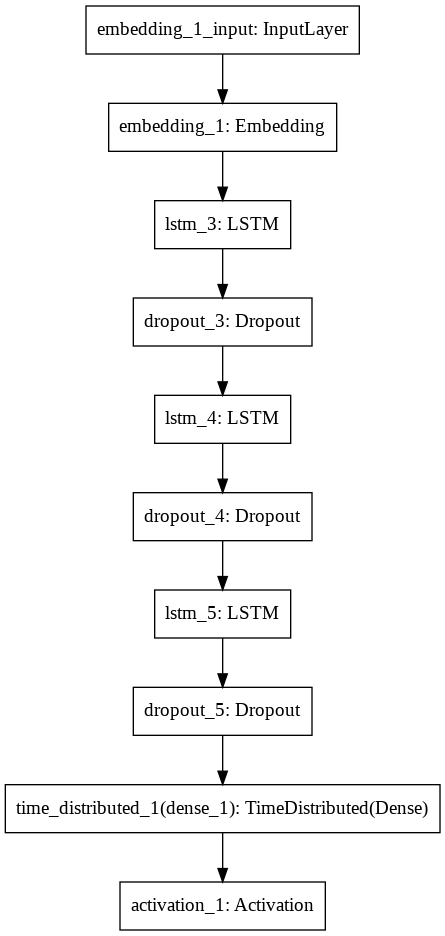

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### Sequence Generation

In [ ]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '6/4': 0.0009652509652509653, '5/4': 0.0009652509652509653}
Generated Dataset Distribution
{'4/4': 0.4659090909090909, '6/8': 0.42045454545454547, '3/4': 0.056818181818181816, '2/4': 0.03409090909090909, '9/8': 0.022727272727272728}

Unique 'M' values to generated dataset: []



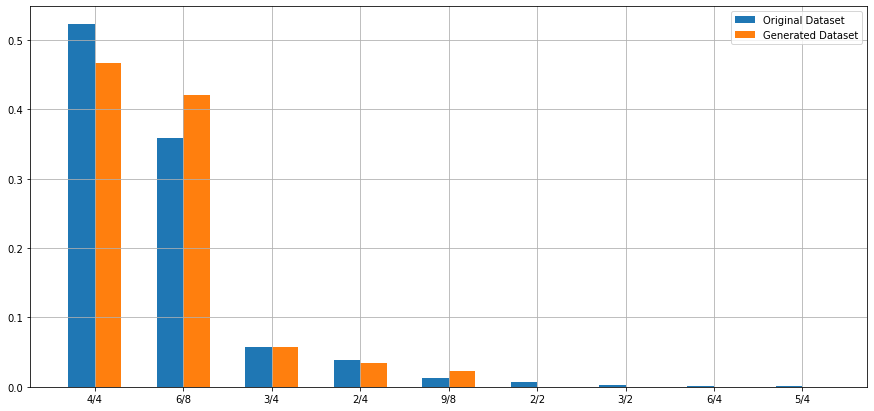

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Gm': 0.010617760617760617, 'Bb': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'Cm': 0.0009652509652509653, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653}
Generated Dataset Distribution
{'D': 0.4891304347826087, 'G': 0.21739130434782608, 'A': 0.11956521739130435, 'C': 0.07608695652173914, 'Em': 0.021739130434782608, 'Am': 0.021739130434782608, 'Bm': 0.010869565217391304, 'F': 0.010869565217391304, 'Dm': 0.010869565217391304, 'B': 0.010869565217391304, '1': 0.010869565217391304}

Unique 'K' values to generated dataset: ['1']



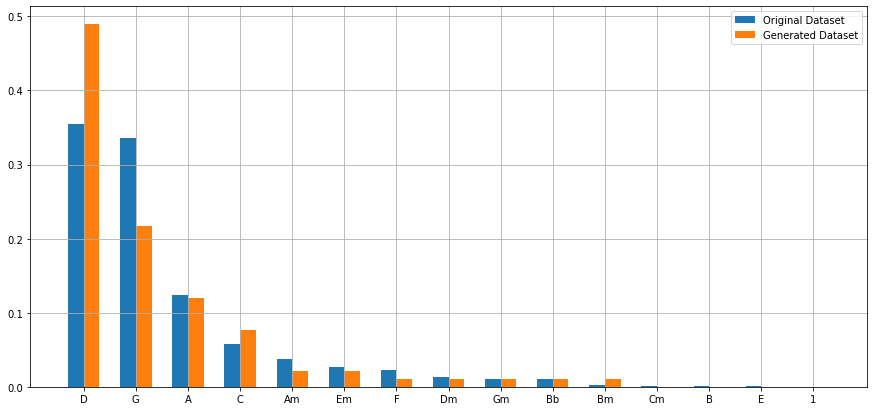

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 299.39
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 13.0%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.3965166008466528
-------------------------------------------------------------------------------------



In [ ]:
seed_index = 76
seq_length = 500

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

# Performance evaluation
evaluate_performance(music_df, generated_df)

### Listening to samples

In [12]:
generated_samples_directory = 'Data/Generated_Samples/Model_2/Baseline/'

In [13]:
# PLAY ME!
play_music(generated_samples_directory + 'sample1.mid')

In [14]:
# PLAY ME!
play_music(generated_samples_directory + 'sample2.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample3.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample4.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample5.mid')

### Observations
- Low error rate but high average max similarity score
- Let's try increasing the number of epochs to 200 (just like we did with Model 1)

## Increasing the number of epochs to 200

### Model Training

In [15]:
model_weights_directory = 'Data/Model_Weights/Model_2/200Epochs/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/200Epochs/'

batch_size = 16
seq_length = 64
num_epochs = 200

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))


model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (16, 64, 512)             47616     
_________________________________________________________________
lstm_3 (LSTM)                (16, 64, 256)             787456    
_________________________________________________________________
dropout_3 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_4 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_4 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_5 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_5 (Dropout)          (16, 64, 256)            

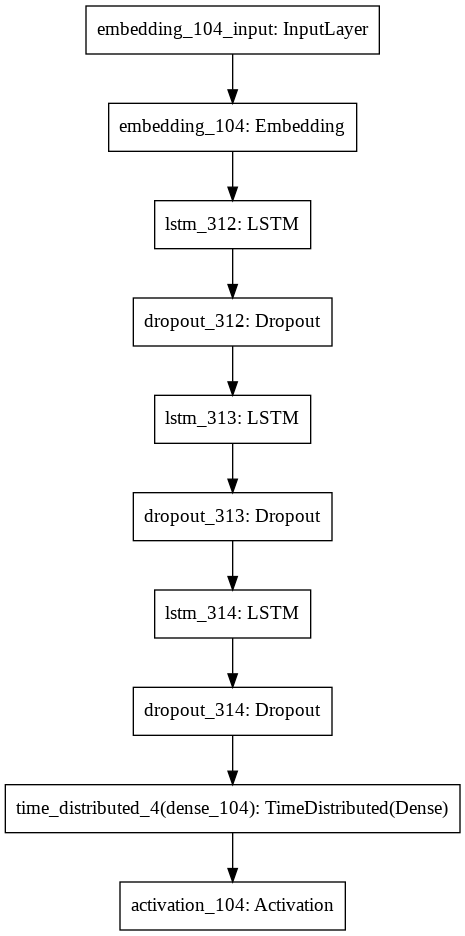

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

### Sequence Generation

In [ ]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '6/4': 0.0009652509652509653, '5/4': 0.0009652509652509653}
Generated Dataset Distribution
{'6/8': 0.4868421052631579, '4/4': 0.39473684210526316, '2/2': 0.02631578947368421, '/8c/8d/8f/8e/8d/8c/8d/8c/8B/8c/8|': 0.013157894736842105, '0/4': 0.013157894736842105, 'e/8': 0.013157894736842105, '9/8': 0.013157894736842105, '6/4': 0.013157894736842105, '8/4': 0.013157894736842105, '|K:G': 0.013157894736842105}

Unique 'M' values to generated dataset: ['/8c/8d/8f/8e/8d/8c/8d/8c/8B/8c/8|', '0/4', 'e/8', '8/4', '|K:G']



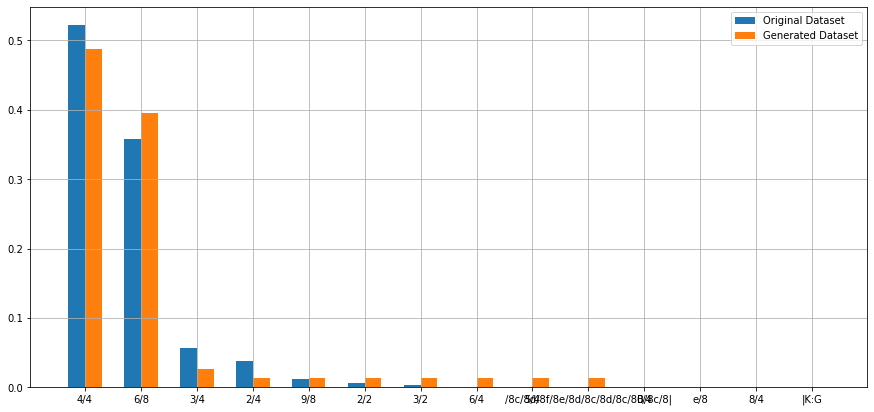

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Gm': 0.010617760617760617, 'Bb': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'Cm': 0.0009652509652509653, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653}
Generated Dataset Distribution
{'D': 0.5263157894736842, 'G': 0.3026315789473684, 'C': 0.07894736842105263, 'A': 0.02631578947368421, 'Em': 0.02631578947368421, 'F': 0.013157894736842105, 'E': 0.013157894736842105, 'Am': 0.013157894736842105}

Unique 'K' values to generated dataset: []



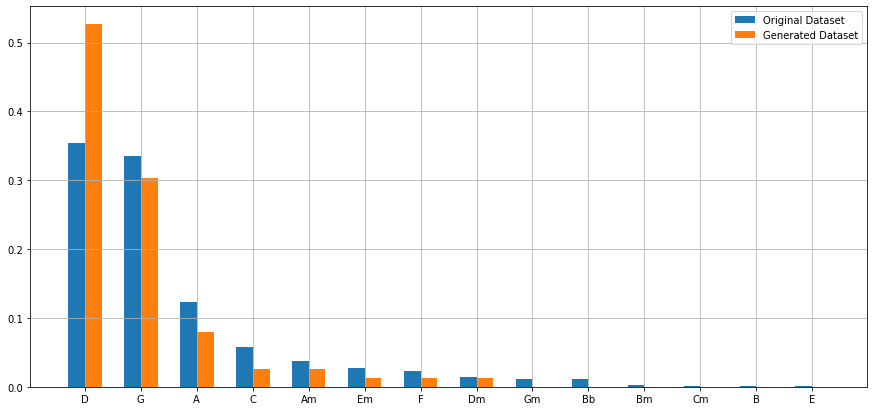

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 278.8
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 28.000000000000004%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.396239238680281
-------------------------------------------------------------------------------------



In [ ]:
seed_index = 76
seq_length = 500

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

evaluate_performance(music_df, generated_df)

### Listening to samples

In [16]:
generated_samples_directory = 'Data/Generated_Samples/Model_2/200Epochs/'

In [17]:
# PLAY ME!
play_music(generated_samples_directory + 'sample1.mid')

In [18]:
# PLAY ME!
play_music(generated_samples_directory + 'sample2.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample3.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample4.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample5.mid')

### Observations
- Didn't help either the error rate or the avg max similarit score
- Might be better to increase the model's complexity instead

## Increasing Complexity - Adding more hidden layers (2)

### Model Training

In [ ]:
model_weights_directory = 'Data/Model_Weights/Model_2/IncreaseComplexity2Layers/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/IncreaseComplexity2Layers/'


batch_size = 16
seq_length = 64
num_epochs = 100

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()



Model: "sequential_406"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_405 (Embedding)    (16, 64, 512)             47616     
_________________________________________________________________
lstm_1215 (LSTM)             (16, 64, 256)             787456    
_________________________________________________________________
dropout_1215 (Dropout)       (16, 64, 256)             0         
_________________________________________________________________
lstm_1216 (LSTM)             (16, 64, 256)             525312    
_________________________________________________________________
dropout_1216 (Dropout)       (16, 64, 256)             0         
_________________________________________________________________
lstm_1217 (LSTM)             (16, 64, 256)             525312    
_________________________________________________________________
dropout_1217 (Dropout)       (16, 64, 256)          

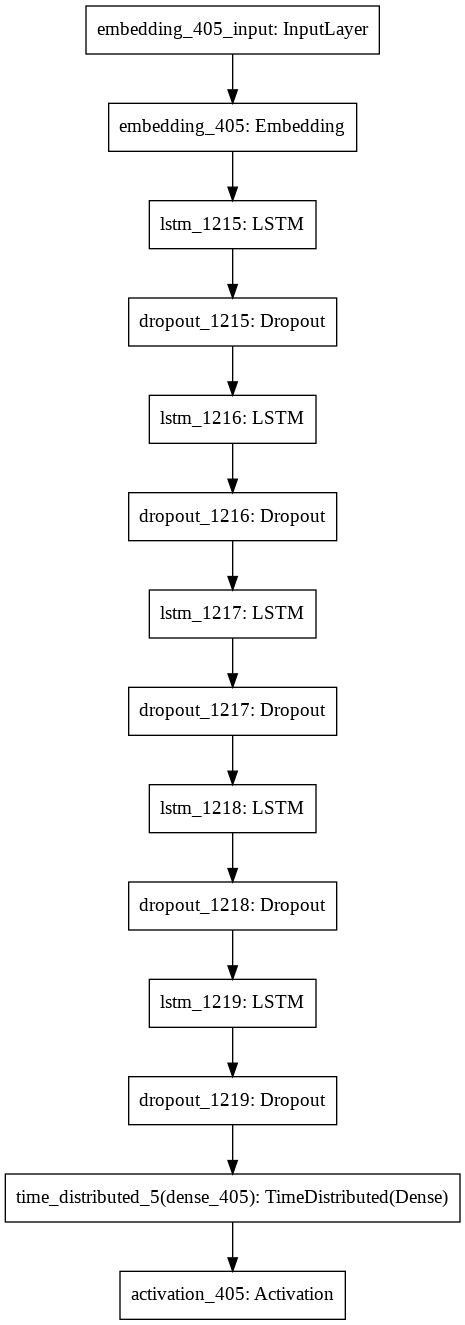

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### Sequence Generation

In [ ]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.2))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '6/4': 0.0009652509652509653, '5/4': 0.0009652509652509653}
Generated Dataset Distribution
{'6/8': 0.6413043478260869, '4/4': 0.30434782608695654, '3/4': 0.021739130434782608, '2/4': 0.021739130434782608, '9/8': 0.010869565217391304}

Unique 'M' values to generated dataset: []



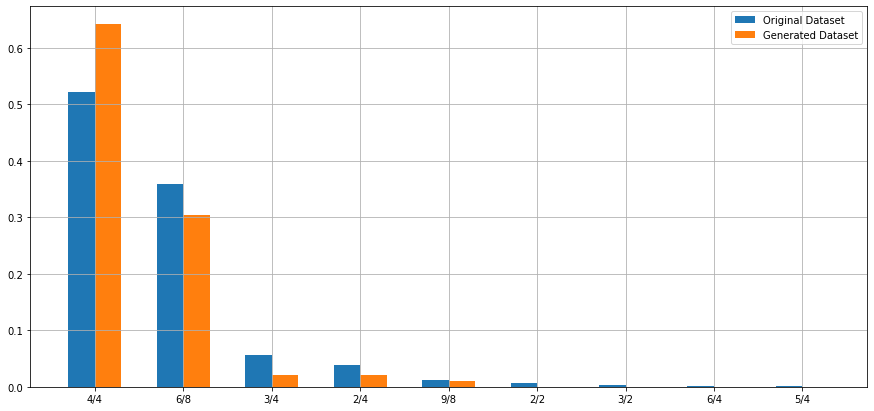

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Gm': 0.010617760617760617, 'Bb': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'Cm': 0.0009652509652509653, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653}
Generated Dataset Distribution
{'D': 0.4148936170212766, 'G': 0.24468085106382978, 'A': 0.13829787234042554, 'C': 0.07446808510638298, 'Bb': 0.0425531914893617, 'Am': 0.0425531914893617, 'F': 0.010638297872340425, 'Dm': 0.010638297872340425, 'E': 0.010638297872340425, 'Em': 0.010638297872340425}

Unique 'K' values to generated dataset: []



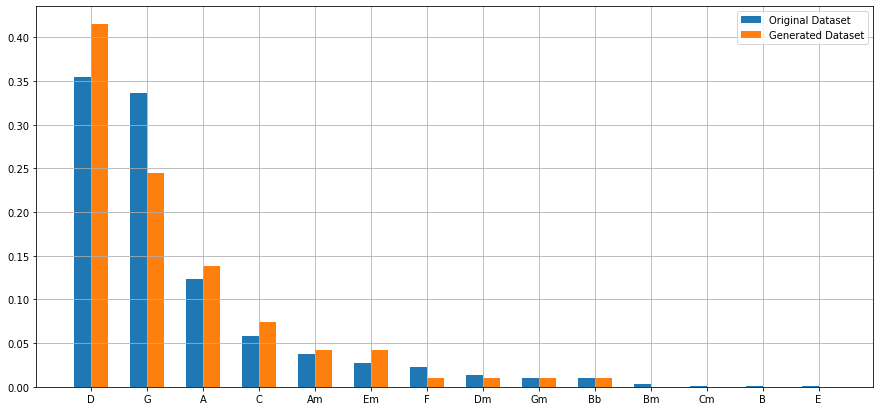

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 290.8
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 9.0%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.4020779440508132
-------------------------------------------------------------------------------------



In [ ]:
seed_index = 76
seq_length = 500

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

# Performance evaluation
evaluate_performance(music_df, generated_df)

### Listening to samples

In [19]:
generated_samples_directory = 'Data/Generated_Samples/Model_2/IncreaseComplexity2Layers/'

In [20]:
# PLAY ME!
play_music(generated_samples_directory + 'sample1.mid')

In [21]:
# PLAY ME!
play_music(generated_samples_directory + 'sample2.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample3.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample4.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample5.mid')

### Observations
- Error rate has been reduced to it's lowest, but at the cost of a higher average max similarity score.
- Lets try increasing the dropout

## Setting the dropout to 0.4

### Model Training

In [ ]:
model_weights_directory = 'Data/Model_Weights/Model_2/Dropout0.4_IncrComplexity/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/Dropout0.4_IncrComplexity/'


batch_size = 16
seq_length = 64
num_epochs = 100

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()



Model: "sequential_910"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_909 (Embedding)    (16, 64, 512)             47616     
_________________________________________________________________
lstm_3737 (LSTM)             (16, 64, 256)             787456    
_________________________________________________________________
dropout_3737 (Dropout)       (16, 64, 256)             0         
_________________________________________________________________
lstm_3738 (LSTM)             (16, 64, 256)             525312    
_________________________________________________________________
dropout_3738 (Dropout)       (16, 64, 256)             0         
_________________________________________________________________
lstm_3739 (LSTM)             (16, 64, 256)             525312    
_________________________________________________________________
dropout_3739 (Dropout)       (16, 64, 256)          

In [ ]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### Sequence Generation

In [ ]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '6/4': 0.0009652509652509653, '5/4': 0.0009652509652509653}
Generated Dataset Distribution
{'4/4': 0.632183908045977, '6/8': 0.19540229885057472, '3/4': 0.09195402298850575, '2/4': 0.06896551724137931, '9/8': 0.011494252873563218}

Unique 'M' values to generated dataset: []



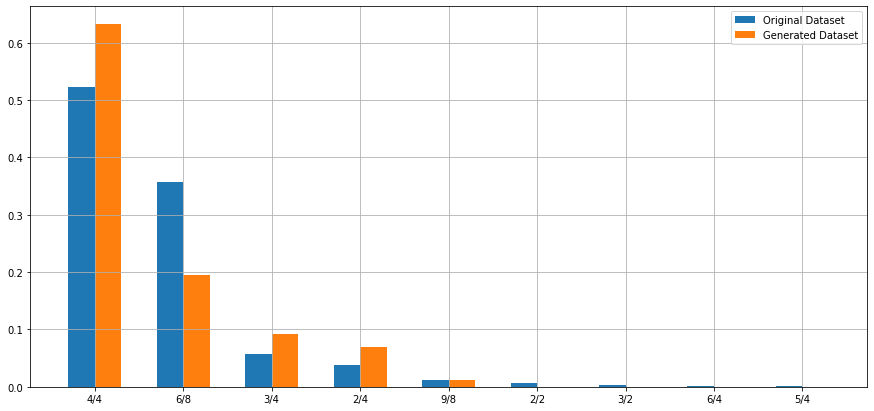

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Gm': 0.010617760617760617, 'Bb': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'Cm': 0.0009652509652509653, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653}
Generated Dataset Distribution
{'D': 0.3888888888888889, 'G': 0.2777777777777778, 'A': 0.16666666666666666, 'C': 0.05555555555555555, 'Am': 0.05555555555555555, 'F': 0.044444444444444446, 'Bm': 0.011111111111111112}

Unique 'K' values to generated dataset: []



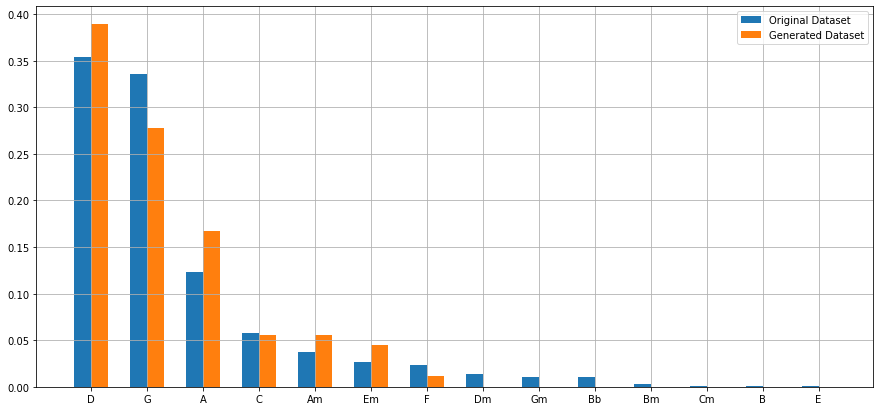

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 359.67
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 16.0%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.36654814758757026
-------------------------------------------------------------------------------------



In [ ]:
seed_index = 76
seq_length = 500

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

#Performance evaluation
evaluate_performance(music_df, generated_df)

### Listening to samples

In [22]:
generated_samples_directory = 'Data/Generated_Samples/Model_2/Dropout0.4_IncrComplexity/'

In [23]:
# PLAY ME!
play_music(generated_samples_directory + 'sample1.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample2.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample3.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample4.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample5.mid')

### Observations
 - Avg max similarity score has reduced, however the error rate has increased. This is expected. 
 - Let's try to get the avg max similarity score as low as possible while keeping the error rate constant

## Further increasing dropout to 0.6

### Model Training

In [ ]:
model_weights_directory = 'Data/Model_Weights/Model_2/Dropout0.6_IncrComplexityMoreUnits/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/Dropout0.6_IncrComplexityMoreUnits/'

batch_size = 16
seq_length = 64
num_epochs = 200

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.6))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.6))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.6))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.6))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.6))

model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, 64, 512)             47616     
_________________________________________________________________
lstm (LSTM)                  (16, 64, 256)             787456    
_________________________________________________________________
dropout (Dropout)            (16, 64, 256)             0         
_________________________________________________________________
lstm_1 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_1 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_2 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_2 (Dropout)          (16, 64, 256)             0

In [ ]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

### Sequence Generation

In [ ]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.6))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.6))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.6))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.6))

    generator_model.add(LSTM(256, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.6))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '5/4': 0.0009652509652509653, '6/4': 0.0009652509652509653}
Generated Dataset Distribution
{'2/4': 0.5, '6/8': 0.5}

Unique 'M' values to generated dataset: []



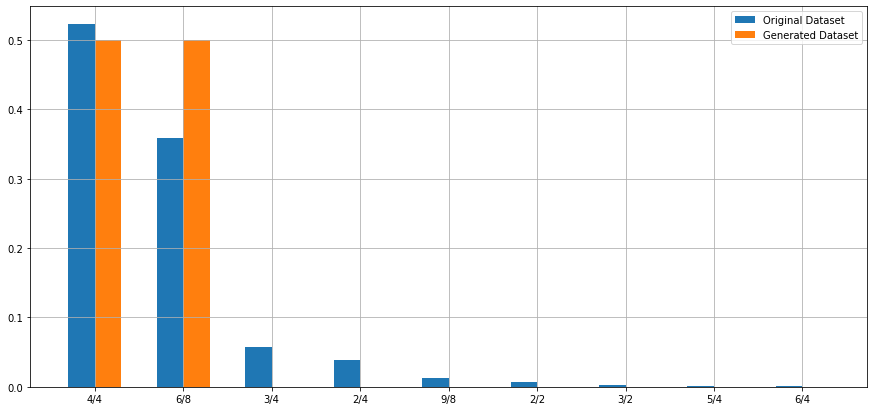

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Gm': 0.010617760617760617, 'Bb': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653, 'Cm': 0.0009652509652509653}
Generated Dataset Distribution
{'G': 0.5, 'E': 0.5}

Unique 'K' values to generated dataset: []



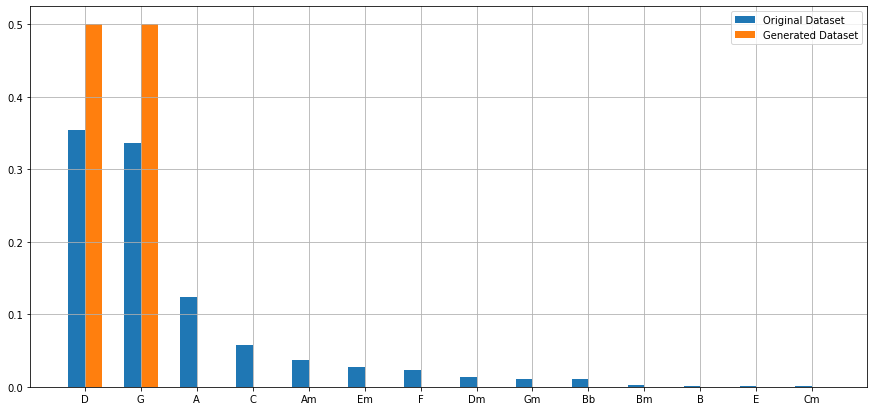

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 9.15
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 98.0%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.010514457524242743
-------------------------------------------------------------------------------------



In [ ]:
seed_index = 76
seq_length = 500

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

evaluate_performance(music_df, generated_df)

### Listening to samples - none

### Observations
 - That didn't work. Let's try keeping the dropout constant and increasing the model complexity instead

## Increasing model complexity - doubling hidden units in all layers

### Model Training

In [27]:
# Ignore the folder names here! 
model_weights_directory = 'Data/Model_Weights/Model_2/Dropout0.5_IncrComplexityMoreUnits/'
generated_samples_directory = 'Data/Generated_Samples/Model_2/Dropout0.5_IncrComplexityMoreUnits/'


batch_size = 16
seq_length = 64
num_epochs = 200

optimizer_ = tf.keras.optimizers.Adam()

model = Sequential()    
model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (batch_size, seq_length))) 

model.add(LSTM(512, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(512, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(512, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(512, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(LSTM(512, return_sequences = True, stateful = True))
model.add(Dropout(0.4))

model.add(TimeDistributed(Dense(num_unique_chars)))

model.add(Activation("softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = optimizer_, metrics = ["accuracy"])
model.summary()



Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_304 (Embedding)    (16, 64, 512)             47616     
_________________________________________________________________
lstm_1520 (LSTM)             (16, 64, 512)             2099200   
_________________________________________________________________
dropout_1520 (Dropout)       (16, 64, 512)             0         
_________________________________________________________________
lstm_1521 (LSTM)             (16, 64, 512)             2099200   
_________________________________________________________________
dropout_1521 (Dropout)       (16, 64, 512)             0         
_________________________________________________________________
lstm_1522 (LSTM)             (16, 64, 512)             2099200   
_________________________________________________________________
dropout_1522 (Dropout)       (16, 64, 512)          

In [28]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")

    for j, (x, y) in enumerate(data_loader(all_characters, num_unique_chars, batch_size, seq_length)):
        loss, accuracy = model.train_on_batch(x, y)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch)))

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

### Sequence Generation

In [29]:
def make_model(num_unique_chars):
    generator_model = Sequential()

    generator_model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 

    generator_model.add(LSTM(512, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(512, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(512, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(512, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add(LSTM(512, return_sequences = True, stateful = True))
    generator_model.add(Dropout(0.4))

    generator_model.add((Dense(num_unique_chars)))

    generator_model.add(Activation("softmax"))

    return generator_model

-------------------------------------------------------------------------------------
Distribution Comparison - Meter / Time Signature

Original Dataset Distribution
{'4/4': 0.5222007722007722, '6/8': 0.3581081081081081, '3/4': 0.05694980694980695, '2/4': 0.03861003861003861, '9/8': 0.012548262548262547, '2/2': 0.006756756756756757, '3/2': 0.0028957528957528956, '5/4': 0.0009652509652509653, '6/4': 0.0009652509652509653}
Generated Dataset Distribution
{'4/4': 0.43434343434343436, '6/8': 0.41414141414141414, '3/4': 0.12121212121212122, '9/8': 0.020202020202020204, '2/4': 0.010101010101010102}

Unique 'M' values to generated dataset: []



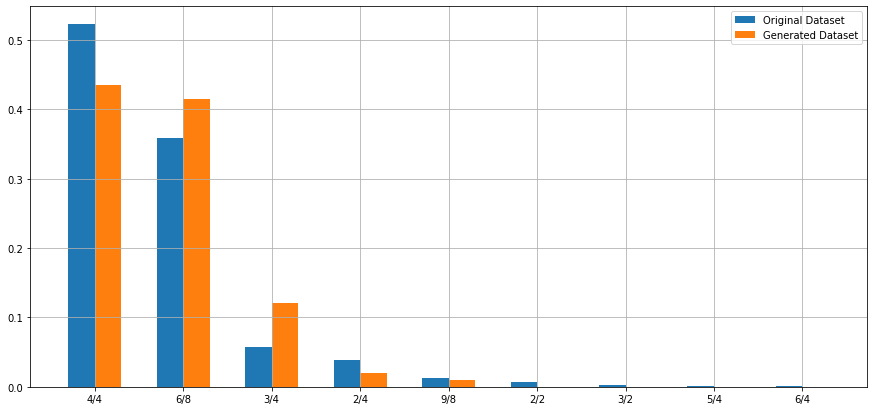

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Distribution Comparison - Key

Original Dataset Distribution
{'D': 0.35424710424710426, 'G': 0.3359073359073359, 'A': 0.12355212355212356, 'C': 0.05791505791505792, 'Am': 0.037644787644787646, 'Em': 0.02702702702702703, 'F': 0.023166023166023165, 'Dm': 0.013513513513513514, 'Bb': 0.010617760617760617, 'Gm': 0.010617760617760617, 'Bm': 0.0028957528957528956, 'B': 0.0009652509652509653, 'E': 0.0009652509652509653, 'Cm': 0.0009652509652509653}
Generated Dataset Distribution
{'D': 0.3838383838383838, 'G': 0.2828282828282828, 'A': 0.15151515151515152, 'C': 0.08080808080808081, 'F': 0.020202020202020204, 'Bm': 0.020202020202020204, 'Bb': 0.020202020202020204, 'Em': 0.020202020202020204, 'Dm': 0.010101010101010102, '|"D"afa "A7"gg^fe|"D"f4e2 d2f2|"D7"d2 efg2|"A"eaaf e4|"A7"cBcB Acec|': 0.010101010101010102}

Unique 'K' val

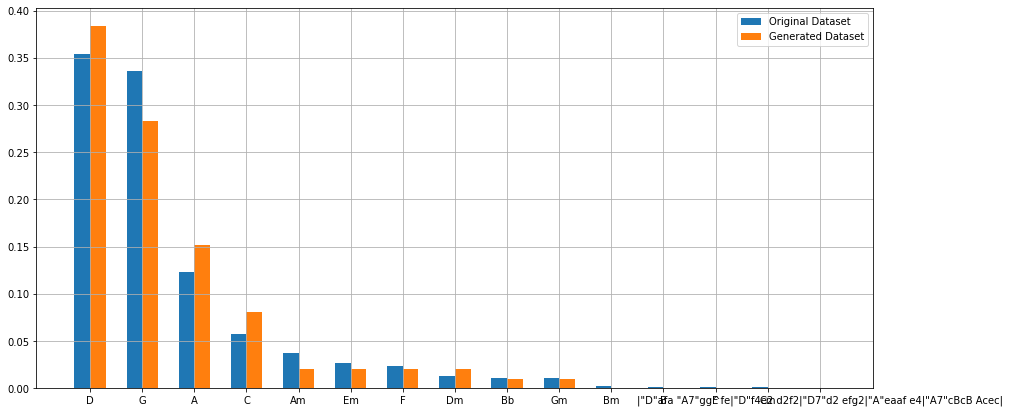

-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Length Comparison
Original Average Transcription Length - 334.4150579150579
Generated Average Transcription Length - 313.01
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Error Rate - 2.0%
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Average Max Similarity Score - 0.40620781042510706
-------------------------------------------------------------------------------------



In [30]:
seed_index = 84
seq_length = 1200

music = ''
all_rows = []

for k in range(100):

    generated_sample = generate_sequence(epoch_num = 200, initial_index = seed_index, seq_length = seq_length)
    all_rows.append(convert_sample_to_dict(generated_sample))

    music += generated_sample
    music += '\n'
    music += '\n'


# Write samples to file 
textfile = open(generated_samples_directory+'generated_samples.txt', 'w')
textfile.write(music)
textfile.close()

# Converting samples to a dataframe
generated_df = pd.DataFrame(all_rows)

evaluate_performance(music_df, generated_df)

### Listening to samples

In [25]:
# PLAY ME!
play_music(generated_samples_directory + 'sample1.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample2.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample3.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample4.mid')

In [ ]:
# PLAY ME!
play_music(generated_samples_directory + 'sample5.mid')

### Observations
 - Clearly overfitting